# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [1]:
%%time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from ml.visualization import plot_confusion_matrix, classifier_boundary, plot_learning_curve

from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron, Ridge
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report

from sklearn.metrics import roc_curve, auc



np.random.seed(0)  # Para mayor determinismo

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.
CPU times: user 2.53 s, sys: 1.75 s, total: 4.28 s
Wall time: 4.47 s


## Carga de datos

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [2]:
%%time

dataset = pd.read_csv("./data/loan_data.csv", comment="#")
display(dataset.head())

# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106


CPU times: user 219 ms, sys: 15.6 ms, total: 234 ms
Wall time: 284 ms


| Name    |Description                                           |
|---------|------------------------------------------------------|
| TARGET  |Label: 1 = client defaulted on loan ; 0 = loan repaid |
| LOAN    |Amount of the loan request                            |
| MORTDUE |Amount due on existing mortgage                       |
| VALUE   |Value of current property                             |
| YOJ     |Years at present job                                  |
| DEROG   |Number of major derogatory reports                    |
| DELINQ  |Number of delinquent credit lines                     |
| CLAGE   |Age of oldest trade line in months                    |
| NINQ    |Number of recent credit lines                         |
| CLNO    |Number of credit lines                                |
| DEBTINC |Debt-to-income ratio                                  |

In [3]:
#dataset.shape

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1854 entries, 0 to 1853
Data columns (total 11 columns):
TARGET     1854 non-null int64
LOAN       1854 non-null int64
MORTDUE    1854 non-null float64
VALUE      1854 non-null float64
YOJ        1854 non-null float64
DEROG      1854 non-null float64
DELINQ     1854 non-null float64
CLAGE      1854 non-null float64
NINQ       1854 non-null float64
CLNO       1854 non-null float64
DEBTINC    1854 non-null float64
dtypes: float64(9), int64(2)
memory usage: 159.4 KB


## Ejercicio 1: División de datos en conjuntos de entrenamiento y evaluación

La primer tarea consiste en dividir el conjunto de datos cargados en el apartado anterior en conjuntos de entrenamiento (o *training*) y evaluación (o *test*).

El primero será utilizado para la creación/selección del modelo de clasificación. El segundo se utilizará sólo al final (una vez elegidos los mejores hiperparámetros) para ver cuál es el resultado final del modelo sobre un conjunto de datos independiente.

In [5]:
# TODO: Dividir en datos de entrenamiento y evaluación

porce_val = 20

X_train, X_test, y_train, y_test = train_test_split(X , y, test_size= (porce_val / 100), shuffle=True)

print("Total de datos:         ",len(X))
print("Datos de entrenamiento: ",len(X_train))
print("Datos de validacion:    ",len(X_test))


Total de datos:          1854
Datos de entrenamiento:  1483
Datos de validacion:     371


## Ejercicio 2: Elección de un modelo

Basándose en lo visto en el teórico escojan y justifiquen un modelo de aprendizaje automático. Recuerden que los pasos para elegir un modelo son:

### Selección de hipótesis

*TODO*

### Selección de regularizador

*TODO*

### Selección de función de coste

*TODO*

### Justificación de las selecciones

*TODO*

## Ejercicio 3: Selección de hiperparámetros

Utilizando búsqueda exhaustiva (*grid search*) con *5-fold cross-validation* y utilizando como métrica el área bajo la curva de ROC (o *ROC-AUC*), hagan una selección de los mejores hiperparámetros para su conjunto de datos y el modelo que hayan elegido en el apartado anterior.

# Búsqueda de hiperparámetros usando: roc_auc

################### l1 ###################

Accuracy conjunto de entrenamiento: 0.87

Mejores parámetros para el conjunto de entrenamiento:

{'C': 0.25, 'max_iter': 5000, 'tol': 0.001}

Grid scores de datos de entrenamiento:

0.708 (+/-0.114) for {'C': 0.01, 'max_iter': 5000, 'tol': 0.001}
0.708 (+/-0.114) for {'C': 0.01, 'max_iter': 5000, 'tol': 0.0001}
0.708 (+/-0.114) for {'C': 0.01, 'max_iter': 5000, 'tol': 1e-05}
0.708 (+/-0.114) for {'C': 0.01, 'max_iter': 10000, 'tol': 0.001}
0.708 (+/-0.114) for {'C': 0.01, 'max_iter': 10000, 'tol': 0.0001}
0.708 (+/-0.114) for {'C': 0.01, 'max_iter': 10000, 'tol': 1e-05}
0.708 (+/-0.114) for {'C': 0.01, 'max_iter': 15000, 'tol': 0.001}
0.708 (+/-0.114) for {'C': 0.01, 'max_iter': 15000, 'tol': 0.0001}
0.708 (+/-0.114) for {'C': 0.01, 'max_iter': 15000, 'tol': 1e-05}
0.769 (+/-0.079) for {'C': 0.05, 'max_iter': 5000, 'tol': 0.001}
0.769 (+/-0.079) for {'C': 0.05, 'max_iter': 5000, 'tol': 0.0001}
0.

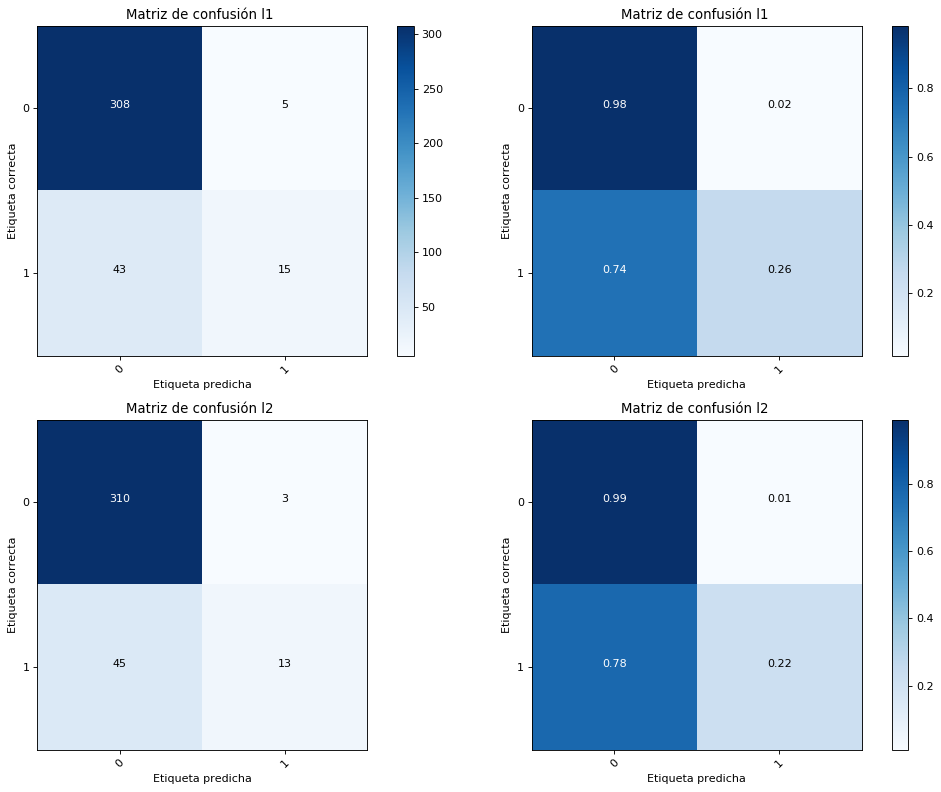

In [6]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py

n_cross_validation = 5
score = 'roc_auc'

#LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
#                   intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
#                   penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
#                   verbose=0, warm_start=False)

param_grid = {
    'C':[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.8, 0.9],
    'tol': [1e-3, 1e-4, 1e-5], 
    'max_iter': [5000,10000,15000]
}    

print("# Búsqueda de hiperparámetros usando: %s" % score)
print()

plt.figure(figsize=(14, 10), dpi= 80, facecolor='w', edgecolor='k')

for i,penalty in enumerate(('l1', 'l2')):
    
    m = LogisticRegression(penalty = penalty)    
    clf = GridSearchCV(estimator=m, param_grid=param_grid, cv=n_cross_validation, scoring=score)
    clf.fit(X_train, y_train)
    
    print('################### '+penalty+' ###################')
    print()
    print('Accuracy conjunto de entrenamiento: %.2f' % accuracy_score(y_train, clf.predict(X_train)))
    print()   
    print("Mejores parámetros para el conjunto de entrenamiento:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores de datos de entrenamiento:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()    
    print("Classification report:")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print('Accuracy conjunto de validación : %.2f' % accuracy_score(y_true, y_pred))     
    print()
    print(classification_report(y_true, y_pred))
    print()
    print('----------------------------------------------------------------------------------------')
    print()
    
    plt.subplot(2, 2, 2*i+1)
    plot_confusion_matrix(confusion_matrix(y_true, y_pred),classes=[0,1], normalize=False,
                          title="Matriz de confusión %s " %penalty)      
    plt.subplot(2, 2, 2*i+2)
    plot_confusion_matrix(confusion_matrix(y_true, y_pred),classes=[0,1], normalize=True,
                          title="Matriz de confusión %s " %penalty) 

## Ejercicio 4: Métricas sobre el conjunto de evaluación

Una vez encontrados los mejores hiperparámetros para el modelo seleccionado en los apartados anteriores se evalúa el modelo final entrenado sobre el conjunto de datos de evaluación seleccionado en el ejercicio 1. Pueden utilizar las métricas que crean convenientes. Es mejor utilizar más de una métrica. Particularmente el *reporte de clasificación* y la *matriz de confusión* son buenos ejemplos de métricas.

In [7]:
# Graficado en celda anterior

## Ejercicio 5 (opcional): Curvas de ROC

Como ejercicio adicional (opcional), pueden redefinir el umbral de decisión óptimo del problema a partir de los resultados que muestren curvas de ROC como justificación. 

Pueden ver esto mediante la [graficación de las curvas de ROC](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html). En el link que se les brinda se muestra como hacer para graficar curvas de ROC para problemas multiclase. Sin embargo se puede adaptar fácilmente a un problema binario obviando la parte donde se calcula la curva clase por clase.

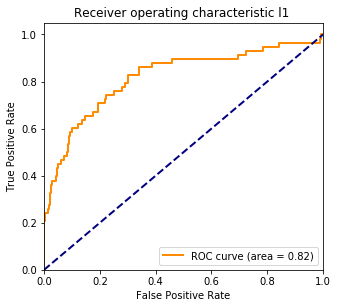

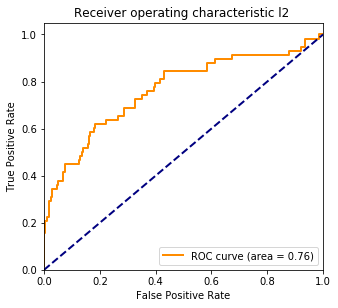

In [8]:
for i,penalty in enumerate(('l1', 'l2')):
    m = LogisticRegression(penalty = penalty)    
    clf = GridSearchCV(estimator = m, param_grid = param_grid, cv = n_cross_validation, scoring = score)
    y_score = clf.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5, 10))

    plt.subplot(2, 1, i+1)
        
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic %s ' %penalty)
    plt.legend(loc="lower right")
    plt.show()